Workflow validation and model enseble for discovering PARP inhibidors.

### Defs and imports

In [1]:
import bin.sdf_scores as sdf

import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Load validation data

$chembl_table$ is an extract of PARP inhibidors downloaded from https://www.ebi.ac.uk/chembl/ 

In [2]:
chembl_table = pd.read_csv("outputs/PARP_sep_2023/chembl.tsv", sep="\t") 
chembl_table = chembl_table[chembl_table[chembl_table.columns[0]].notna()]
chembl_table.set_index(chembl_table.columns[0], inplace=True)

### Load modelling results for the validation data

gnina model - https://github.com/dkoes/GNINA-1.0/tree/main https://doi.org/10.1186/s13321-021-00522-2

swiss adme - http://www.swissadme.ch/ https://doi.org/10.1038/srep42717

crismod - molecular meachanics model from cancerappy, see the paper for details

In [3]:
gnina_chembl = sdf.get_gnina_scores('outputs/PARP_sep_2023/gnina/val')

[15:22:02] Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] ERROR: Could not sanitize molecule ending on line 6333
[15:22:02] ERROR: Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] ERROR: Could not sanitize molecule ending on line 6402
[15:22:02] ERROR: Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] ERROR: Could not sanitize molecule ending on line 6471
[15:22:02] ERROR: Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] ERROR: Could not sanitize molecule ending on line 6540
[15:22:02] ERROR: Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] Explicit valence for atom # 20 O, 3, is greater than permitted
[15:22:02] ERROR: Could not sanitize molec

In [4]:
data = pd.read_csv("outputs/PARP_sep_2023/crismod/swissadme.csv", sep=",")
adme_chembl = data.drop(["Canonical SMILES","Formula","BBB permeant","Pgp substrate","CYP1A2 inhibitor",
           "CYP2C19 inhibitor","CYP2C9 inhibitor","CYP2D6 inhibitor","CYP3A4 inhibitor",
           "ESOL Class","Ali Class","Silicos-IT class","GI absorption"], axis=1)
adme_columns = set(adme_chembl.columns)-set(["Molecule"])

In [5]:
data = pd.read_csv("outputs/PARP_sep_2023/crismod/7KK4_chembl_affinity.dat", sep=",")
data["Pose"] = 0
for key, row in data.iterrows():
    combined_name = row.Ligand.split("_") 
    data.at[key,'Ligand'] = combined_name[0]
    data.at[key,'Pose'] = int(combined_name[1])
    #if combined_name[0] in chebl_names:
    ki = chembl_table.loc[combined_name[0]]["Standard Value"]* 10**-9
    data.at[key,'val_ki'] = ki
    data.at[key,'val_Energy'] = 0.6 * math.log(ki)
    #else:
    #    data.at[key,'val_Energy'] = 0
        
crismod_chembl = data

## merge the results

In [6]:
data = crismod_chembl.drop(["Protein","ID","Pose"], axis=1)

for key, row in data.iterrows():
    gnina_row = gnina_chembl[gnina_chembl.Name == row.Ligand].iloc[0]
    
    if len(adme_chembl[adme_chembl.Molecule == row.Ligand]) == 0:
        print(gnina_row.SMILES, gnina_row.Name)
    else:
        adme_row = adme_chembl[adme_chembl.Molecule == row.Ligand].iloc[0]

        data.at[key,'Energy'] = gnina_row.Energy
        data.at[key,'CNNscore'] = gnina_row.CNNscore
        data.at[key,'CNNaffinity'] = gnina_row.CNNaffinity
        data.at[key,'CNN_VS'] = gnina_row.CNN_VS
        data.at[key,'CNNaffinity_variance'] = gnina_row.CNNaffinity_variance
        data.at[key,'SMILES'] = gnina_row.SMILES

        for column in adme_columns:
            data.at[key,column] = adme_row[column]
        
    
chembl_res = data

### Test which model is the best performer

In [7]:
filtered_data = crismod_chembl[crismod_chembl.Pose == 0]

x_cols = ["MMPBSA","MMGBSA_2","MMGBSA_5","MMGBSA_7","MMGBSA_8"]

for x_col in x_cols:
    corelation = filtered_data[x_col].corr(filtered_data["val_Energy"])
    print(x_col+" "+str(corelation))

MMPBSA -0.005017236945645728
MMGBSA_2 0.16986954874937132
MMGBSA_5 0.22232329944500873
MMGBSA_7 0.042623436902546656
MMGBSA_8 0.015464309490273585


# Model ensemble

In [8]:
X = chembl_res.drop(['val_Energy', 'Ligand','val_ki','SMILES'], axis=1)  # dropping 'Ligand' assuming it's categorical/non-numeric
y = chembl_res['val_Energy']

## Set the training target

The model is trained to distinguish betwean compounds that have some activity and compounds that perform very well. It is not trained to detect inhibitors as we assume that when the ensemble is used the compounds have already been filtered enough.

In [9]:
Ki_threshold = 1.0e-08 # 10 nano
chembl_res["Strong_inhibitor"] = chembl_res.val_ki<Ki_threshold

### Test which parameters improove the predictions

In [10]:
always_drop = ['val_Energy', 'Ligand','val_ki','SMILES','Strong_inhibitor',"CNNaffinity_variance","MMPBSA","CNNscore","MMGBSA_8","CNN_VS","MMGBSA_2"]
MM_models = ["Energy","CNNaffinity","MMGBSA_5","MMGBSA_7"]

In [11]:
res=dict()
for j in range(1000): # repeat to handle noise
    for i in range(len(MM_models)+1):

        drop_list = MM_models.copy()
        if i < len(MM_models):
            model = "No"+MM_models[i]
            drop_list = [MM_models[i]]
        else:
            model = "Ensemble"
            drop_list = []
            
        #drop_list = ["MMPBSA","MMGBSA_2","MMGBSA_8"]
            
        X = chembl_res.drop(always_drop, axis=1)  # dropping 'Ligand' assuming it's categorical/non-numeric
        X = X.drop(adme_columns, axis=1) 
        X = X.drop(drop_list, axis=1)

        y = chembl_res['Strong_inhibitor']

        # Splitting the dataset into the Training set and Test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Feature Scaling (important for algorithms like logistic regression)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Create and train model
        classifier = LogisticRegression()
        classifier.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier.predict(X_test)

        y_probs = classifier.predict_proba(X_test)
        y_probs_positive = y_probs[:, 1]

        # Calculate AUC score (a single number evaluating the model performance)
        roc_auc = roc_auc_score(y_test, y_probs_positive)
        
        if model in res:
            res[model] = res[model] + roc_auc
        else:
            res[model] = roc_auc
        

In [12]:
res

{'NoEnergy': 812.5462510839182,
 'NoCNNaffinity': 823.6103744386312,
 'NoMMGBSA_5': 789.8794879232865,
 'NoMMGBSA_7': 763.9093459435585,
 'Ensemble': 846.4471367935076}

### Do ADME variables improove the model?

In [13]:
# Try adding one by one the best variables, on top of the MM and gnina variables identified earlier
res=dict()
adme_columns = set(adme_chembl.columns)-set(["Molecule"])
always_drop = ['val_Energy', 'Ligand','val_ki','SMILES','Strong_inhibitor',"CNNaffinity_variance","MMPBSA",
               "CNNscore","MMGBSA_8","CNN_VS","MMGBSA_2"]

test_list = ['log Kp (cm/s)', '#H-bond donors']
adme_columns = list(set(adme_columns)-set(test_list))

always_drop = always_drop+adme_columns

adme_columns = test_list

for j in range(1000):
    for i in range(len(adme_columns)+2):

        drop_list = adme_columns.copy()
        if i < len(adme_columns):
            model = adme_columns[i]
            del drop_list[i]

        elif i == len(adme_columns):
            model = "ADME"
            drop_list = [] 
        else:
            model = "NO ADME"

            
        X = chembl_res.drop(always_drop, axis=1)  # dropping 'Ligand' assuming it's categorical/non-numeric
        X = X.drop(drop_list, axis=1)

        y = chembl_res['Strong_inhibitor']

        # Splitting the dataset into the Training set and Test set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Feature Scaling (important for algorithms like logistic regression)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Create and train model
        classifier = LogisticRegression()
        classifier.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier.predict(X_test)

        y_probs = classifier.predict_proba(X_test)
        y_probs_positive = y_probs[:, 1]

        # Calculate AUC score (a single number evaluating the model performance)
        roc_auc = roc_auc_score(y_test, y_probs_positive)
        
        if model in res:
            res[model] = res[model] + roc_auc
        else:
            res[model] = roc_auc

In [14]:
res

{'log Kp (cm/s)': 910.1400741299178,
 '#H-bond donors': 851.1640740723398,
 'ADME': 929.1683339436137,
 'NO ADME': 845.455995260357}

# Load the enamine results

## Load crismod results

In [15]:
data = pd.read_csv("outputs/PARP_sep_2023/crismod/7KK4_enamine_affinity.dat", sep=",")
data["Pose"] = 0
for key, row in data.iterrows():
    combined_name = row.Ligand.split("_") 
    data.at[key,'Ligand'] = combined_name[0]
    data.at[key,'Pose'] = int(combined_name[1])
      
crismod_enamine = data

## Load gnina results

In [2]:
gnina_enamine = sdf.get_gnina_scores('outputs/PARP_sep_2023/gnina/sminaout')

outputs/PARP_sep_2023/gnina/sminaout/parp1_gnina_0071.sdf


## Load adme

In [17]:
data = pd.read_csv("outputs/PARP_sep_2023/crismod/swissadme_enamine.csv", sep=",")

In [18]:
adme_enamine = data.drop(["Canonical SMILES","Formula","BBB permeant","Pgp substrate","CYP1A2 inhibitor",
           "CYP2C19 inhibitor","CYP2C9 inhibitor","CYP2D6 inhibitor","CYP3A4 inhibitor",
           "ESOL Class","Ali Class","Silicos-IT class","GI absorption"], axis=1)

In [19]:
adme_columns = set(adme_enamine.columns)-set(["Molecule"])

## merge the results

In [20]:
data = crismod_enamine.drop(["Protein","ID"], axis=1)

for key, row in data.iterrows():
    gnina_rows = gnina_enamine[gnina_enamine.Name == row.Ligand]

    if len(gnina_rows) == 0:
        print("no data for "+row.Ligand)
    else:
        gnina_row = gnina_rows.iloc[0]
        if len(adme_enamine[adme_enamine.Molecule == row.Ligand]) == 0:
            print(gnina_row.SMILES, gnina_row.Name)
        else:
            adme_row = adme_enamine[adme_enamine.Molecule == row.Ligand].iloc[0]
    
            data.at[key,'Energy'] = gnina_row.Energy
            data.at[key,'CNNscore'] = gnina_row.CNNscore
            data.at[key,'CNNaffinity'] = gnina_row.CNNaffinity
            data.at[key,'CNN_VS'] = gnina_row.CNN_VS
            data.at[key,'CNNaffinity_variance'] = gnina_row.CNNaffinity_variance
            data.at[key,'SMILES'] = gnina_row.SMILES
    
            for column in adme_columns:
                data.at[key,column] = adme_row[column]
        
    
enamine_res = data

# Final filtering

## Train the model

In [21]:
adme_columns = set(adme_chembl.columns)-set(["Molecule"])
always_drop = ['val_Energy', 'Ligand','val_ki','SMILES','Strong_inhibitor',"CNNaffinity_variance","MMPBSA",
               "CNNscore","MMGBSA_8","CNN_VS","MMGBSA_2",]

#test_list = ['log Kp (cm/s)', '#H-bond donors']
test_list = []
adme_columns = list(set(adme_columns)-set(test_list))

always_drop = always_drop+adme_columns
      
X = chembl_res.drop(always_drop, axis=1)  # dropping 'Ligand' assuming it's categorical/non-numeric
y = chembl_res['Strong_inhibitor']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01)

# Feature Scaling (important for algorithms like logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

y_probs = classifier.predict_proba(X_test)
y_probs_positive = y_probs[:, 1]

# Calculate AUC score (a single number evaluating the model performance)
roc_auc = roc_auc_score(y_test, y_probs_positive)
        
print(roc_auc)

1.0


## Apply the model to the screening results

In [22]:
X = enamine_res.drop(always_drop+["10nM score short_adme"], axis=1, errors = 'ignore') 
X = X.drop("Pose", axis=1)
X_prod = scaler.transform(X)

# Predicting the Test set results
y_pred_prod = classifier.predict(X_prod)

y_probs_prod = classifier.predict_proba(X_prod)
y_probs_prod_positive = y_probs_prod[:, 1]

In [23]:
#enamine_res["10nM score short_adme"] = y_probs_prod_positive
enamine_res["10nM score no_adme"] = y_probs_prod_positive

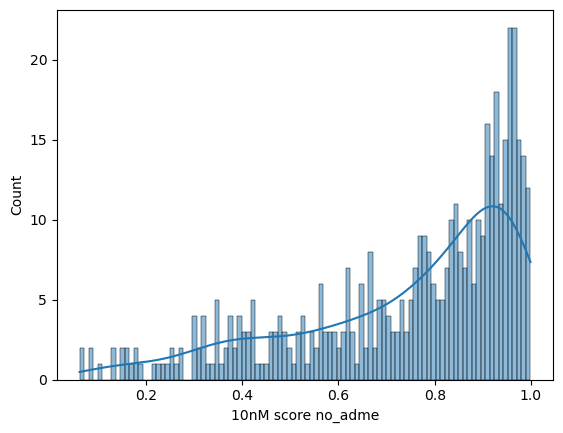

In [24]:
sns.histplot(data=enamine_res, x="10nM score no_adme",
             bins=100,kde=True, cumulative=False, palette="bright")
#plt.savefig("histogram.png", dpi=600)
plt.show()

In [25]:
column_order = ['Ligand', 'SMILES', 'MMGBSA_5', 'MMGBSA_7', 'Energy', 'CNNaffinity', 
                #'10nM score short_adme', 
                'log Kp (cm/s)', '#H-bond donors', '10nM score no_adme',
                'MMPBSA', 'MMGBSA_2', 'MMGBSA_8', 'CNNscore', 'CNN_VS',
                'CNNaffinity_variance', 'XLOGP3', 'Veber #violations',
                'MLOGP', 'Silicos-IT LogSw', 'PAINS #alerts', 'Ali Solubility (mg/ml)',
                'Brenk #alerts', 'Silicos-IT Solubility (mg/ml)', '#Heavy atoms',
                'Ali Log S', '#Aromatic heavy atoms', 'Synthetic Accessibility',
                'Silicos-IT Solubility (mol/l)', '#H-bond acceptors', 'Fraction Csp3',
                'Bioavailability Score', 'MW', 'ESOL Solubility (mg/ml)',
                'ESOL Solubility (mol/l)', 'Silicos-IT Log P', 'Ali Solubility (mol/l)',
                'Egan #violations', 'Muegge #violations', 'TPSA', 'MR',
                'Leadlikeness #violations', 'Consensus Log P', 'ESOL Log S',
                '#Rotatable bonds', 'iLOGP', 'WLOGP',
                'Ghose #violations', 'Lipinski #violations']

## Save the final list

In [26]:
final_res = enamine_res[column_order].sort_values(by='10nM score no_adme', ascending=False)
final_res.to_csv("final_results.csv", index=False)